# Определение стоимости автомобилей

**Цель проекта** - разработка приложение для привлечения новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля.

**Итак, вводные данные такие:** Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В моём распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Исследование предполагает выполнение следующих задач:
1. Загрузить данные;
2. Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их;
3. Подготовить выборки для обучения моделей;
4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры;
5. Проанализировать время обучения, время предсказания и качество моделей;
6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке

В наличии следующие признаки:
1. DateCrawled — дата скачивания анкеты из базы;
2. VehicleType — тип автомобильного кузова;
3. RegistrationYear — год регистрации автомобиля;
4. Gearbox — тип коробки передач;
5. Power — мощность (л. с.);
6. Model — модель автомобиля;
7. Kilometer — пробег (км);
8. RegistrationMonth — месяц регистрации автомобиля;
9. FuelType — тип топлива;
10. Brand — марка автомобиля;
11. Repaired — была машина в ремонте или нет;
12. DateCreated — дата создания анкеты;
13. NumberOfPictures — количество фотографий автомобиля;
14. PostalCode — почтовый индекс владельца анкеты (пользователя);
15. LastSeen — дата последней активности пользователя;

**Целевой признак**
16. Price — цена (евро)

План исследования:

1. Обзор данных;
2. Предобработка данных;
3. Обучение моделей;
4. Выбор лучшей модели и ее тестирование;
5. Вывод.

Начинаю с импорта библиотек.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sb
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import time

Загрузил всё, что вспомнил.

## Подготовка данных

### Загрузка данных

Для подстраховки загружаю через try-except.

In [ ]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except FileNotFoundError:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

Взгляну на содержимое.

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Сразу бросается  в глаза способ наименования столбцов - верблюжий стиль. Я его изменю на змеиный. Кроме того, некоторые столбцы явно не пригодятся в исследовании. Поэтому я от них избавлюсь. Но сначала взгляну на дубликаты.

### Подготовка

In [ ]:
data.duplicated().sum()

4

Число незначительное. Удаляю.

In [ ]:
data.drop_duplicates()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Вот теперь удаляю лишние по моему мнению столбцы:
1. Дата скачивания анкеты из базы;
2. Дата создания анкеты;
3. Дата последней активности пользователя;
4. Кол-во фотографий;
5. Почтовый индекс.

In [ ]:
data = data.drop(["DateCrawled","DateCreated","LastSeen",
                  "NumberOfPictures","PostalCode"],axis = 1)

In [ ]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Теперь вернусь к эстетической стороне. Сначала переведу имена в строчный шрифт.

In [ ]:
data.columns = data.columns.str.lower()
data.head()

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


А затем - в змеиный стиль.

In [ ]:
data = data.rename(columns={'vehicletype': 'vehicle_type', 'registrationyear': 'registration_year',
                           'registrationmonth':'registration_month', 'fueltype':'fuel_type'})
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


Теперь посмотрю на пропуска.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        316879 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gearbox             334536 non-null  object
 4   power               354369 non-null  int64 
 5   model               334664 non-null  object
 6   kilometer           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           321474 non-null  object
 9   brand               354369 non-null  object
 10  repaired            283215 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.7+ MB


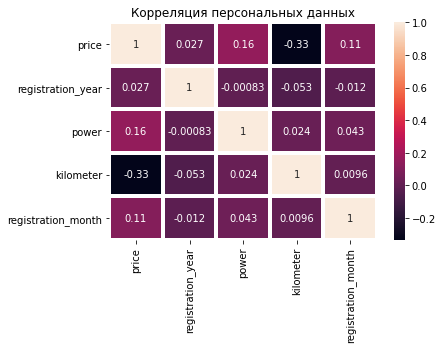

In [ ]:
sb.heatmap(data.corr(), annot=True, linewidths=3, linecolor='white')
plt.title('Корреляция персональных данных')
plt.show()

In [ ]:
data.isna().sum()

price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
dtype: int64

С одной стороны - количество пропусков по пяти столбцам огромно и нужно что-то сделать. С другой - просто заменить каким-то значением отстутвующие данные нельзя. Подумаю. Пока взгляну на некоторые данные для интереса с точки зрения цены.

Text(0.5, 0, 'Цена, руб')

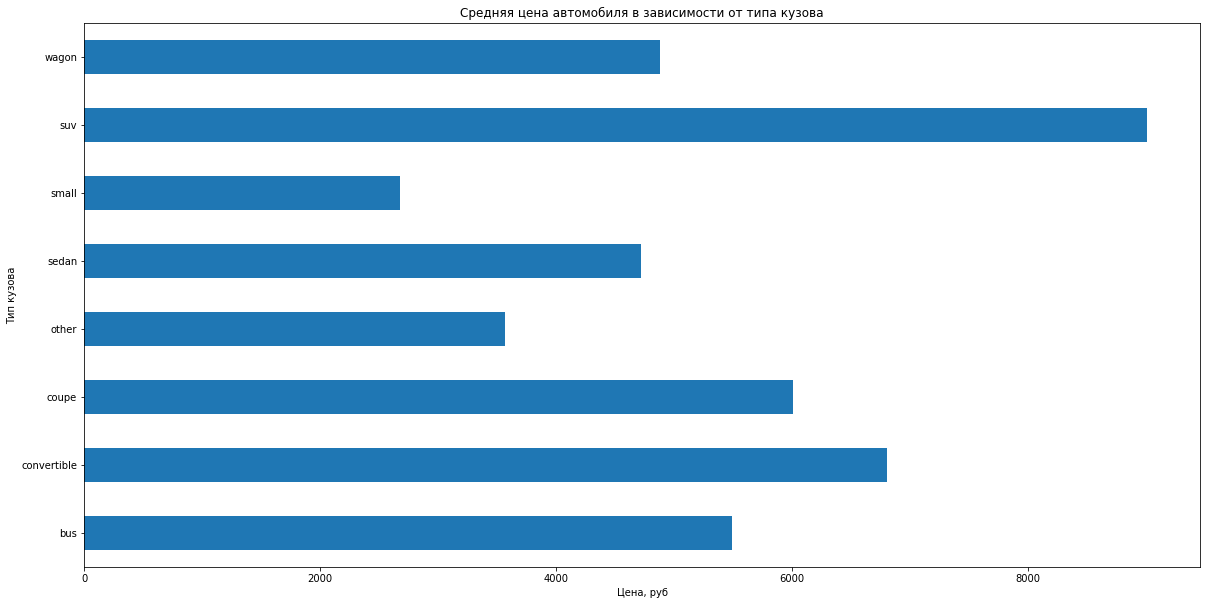

In [ ]:
data.pivot_table(index = 'vehicle_type',
                            values = 'price', aggfunc = 'mean').plot(kind = 'barh',
                                                                     figsize=(20,10),
                                                                     legend = False)
plt.title("Средняя цена автомобиля в зависимости от типа кузова")
plt.ylabel("Тип кузова")
plt.xlabel("Цена, руб")

Text(0.5, 0, 'Цена, руб')

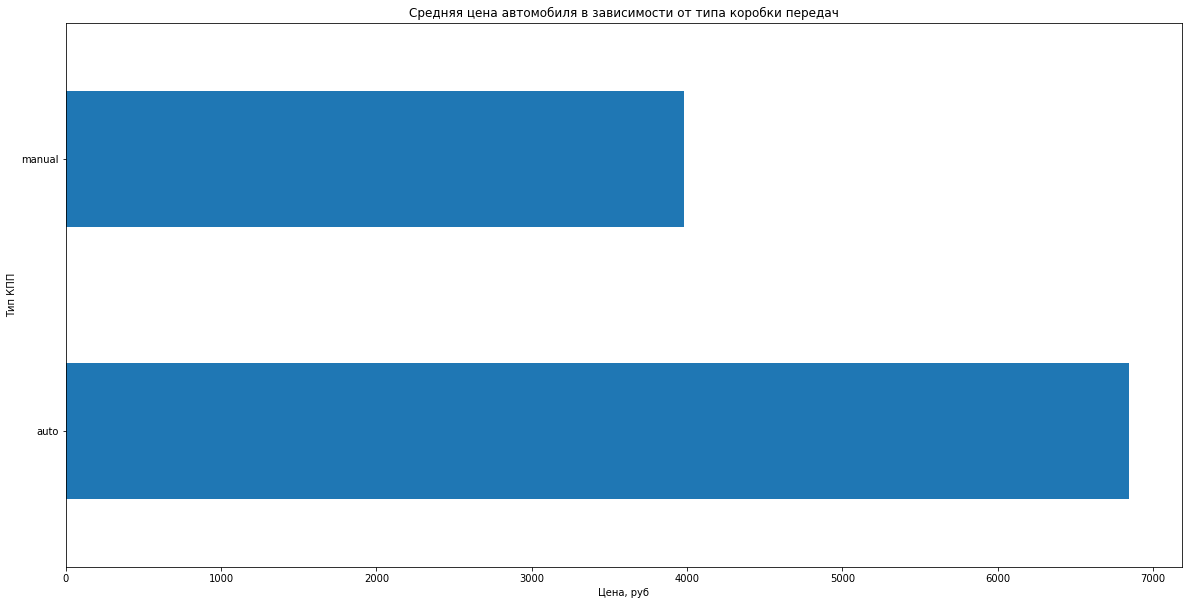

In [ ]:
data.pivot_table(index = 'gearbox',
                            values = 'price', aggfunc = 'mean').plot(kind = 'barh',
                                                                     figsize=(20,10),
                                                                     legend = False)
plt.title("Средняя цена автомобиля в зависимости от типа коробки передач")
plt.ylabel("Тип КПП")
plt.xlabel("Цена, руб")

In [ ]:
data.describe()

,price,registration_year,power,kilometer,registration_month
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


В столбцах с количественными признаками видно "странности". Год регистрации, например. Ограничу периодом 1980-2023. Проверю на боксплоте ещё.

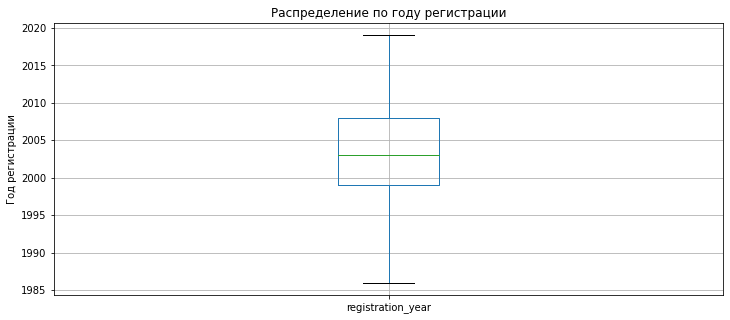

In [ ]:
data.boxplot(column='registration_year', showfliers=False, figsize=(12, 5))
plt.ylabel('Год регистрации')
plt.title('Распределение по году регистрации')
plt.show()

In [ ]:
data = data[(data['registration_year'] >= 1980) & (data['registration_year'] < 2017)]


Мой период даже избыточен, но оставлю как есть.

In [ ]:
data.describe()

,price,registration_year,power,kilometer,registration_month
count,336387.000000,336387.000000,336387.000000,336387.000000,336387.000000
mean,4447.274794,2002.828894,111.366973,128513.839714,5.770615
std,4526.680863,6.081984,185.510237,37473.848050,3.707441
min,0.000000,1980.000000,0.000000,5000.000000,0.000000
25%,1099.000000,1999.000000,70.000000,125000.000000,3.000000
50%,2750.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6499.000000,2007.000000,143.000000,150000.000000,9.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000


Теперь цена. Ну явно должна быть ненулевой. Как-то жёсче отсекать не буду. Возможно, в процессе ревью буду пояснения, как в данном моменте лучше рассуждать.

In [ ]:
data = data[(data['price'] != 0) & (data['price'] > 400)]

In [ ]:
data.describe()

,price,registration_year,power,kilometer,registration_month
count,305744.000000,305744.000000,305744.000000,305744.000000,305744.000000
mean,4876.278867,2003.175981,115.807247,128349.566958,5.951669
std,4530.113634,5.901369,184.826750,36849.628373,3.628428
min,408.000000,1980.000000,0.000000,5000.000000,0.000000
25%,1450.000000,1999.000000,75.000000,125000.000000,3.000000
50%,3200.000000,2003.000000,109.000000,150000.000000,6.000000
75%,6950.000000,2007.000000,147.000000,150000.000000,9.000000
max,20000.000000,2016.000000,20000.000000,150000.000000,12.000000


Теперь мощность.

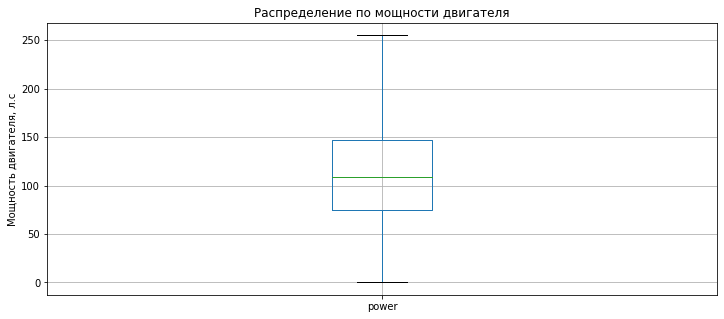

In [ ]:
data.boxplot(column='power', showfliers=False, figsize=(12, 5))
plt.ylabel('Мощность двигателя, л.с')
plt.title('Распределение по мощности двигателя')
plt.show()

In [ ]:
data['brand'].unique()


array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'seat', 'honda',
       'fiat', 'opel', 'mini', 'smart', 'hyundai', 'subaru', 'volvo',
       'mitsubishi', 'alfa_romeo', 'kia', 'suzuki', 'lancia', 'citroen',
       'toyota', 'chevrolet', 'dacia', 'sonstige_autos', 'daihatsu',
       'chrysler', 'jaguar', 'daewoo', 'rover', 'porsche', 'saab',
       'land_rover', 'trabant', 'lada'], dtype=object)

Бугатти нет, поэтому даже 2000 л.с невозможны (сведения из сети). Вот с нижним пределом так уверенно не рассуждаю, сам не автолюбитель. Возьму взятые с потолка 10 л.с.

In [ ]:
data['power'].describe()

count    305744.000000
mean        115.807247
std         184.826750
min           0.000000
25%          75.000000
50%         109.000000
75%         147.000000
max       20000.000000
Name: power, dtype: float64

In [ ]:
data = data[(data['power'] > 70) & (data['power'] <= 1500)]

In [ ]:
data.describe()

,price,registration_year,power,kilometer,registration_month
count,238271.000000,238271.000000,238271.000000,238271.000000,238271.000000
mean,5568.095866,2003.523249,134.607770,129433.103483,6.086712
std,4728.801617,5.735645,54.680478,35908.912540,3.546417
min,408.000000,1980.000000,71.000000,5000.000000,0.000000
25%,1800.000000,2000.000000,101.000000,125000.000000,3.000000
50%,3990.000000,2004.000000,122.000000,150000.000000,6.000000
75%,7999.000000,2008.000000,158.000000,150000.000000,9.000000
max,20000.000000,2016.000000,1500.000000,150000.000000,12.000000


### Промежуточные выводы

По результатам подготовки выполнено следующее:
1. Загружены предоставленные данные;
2. Определены столбцы с пропусками. Заполнять пропуски не стал, пропущенные данные считаю результатом незаполнения. Заполнять их какими бы то ни было значениями считаю неверным;
3. Избавился от 4-х дубликатов;
4. Удалил столбцы, данные по которым посчитал лишними: Дата скачивания анкеты из базы, Дата создания анкеты, Дата последней активности пользователя, Кол-во фотографий, Почтовый индекс;
5. Проверил данные на предмет связи некоторых данных с ценой;
6. Проверил данные на корреляцию - явной корреляции не обнаружено;
7. Согласно бокс-диаграмм, данных из сети и собственному мнению исключён некоторый диапазон данных.

## Обучение моделей

### Подготовка выборок

Подстахуюсь от дамми-ловушки.

In [ ]:
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

In [ ]:
data['vehicle_type'] = data['vehicle_type'].astype('category').cat.codes
data['gearbox'] = data['gearbox'].astype('category').cat.codes
data['model'] = data['model'].astype('category').cat.codes
data['fuel_type'] = data['fuel_type'].astype('category').cat.codes
data['brand'] = data['brand'].astype('category').cat.codes
data['repaired'] = data['repaired'].astype('category').cat.codes

Разобью выборки на обучающую, тестовую и валидационную в соотношении 80/10/10 соответственно.

In [ ]:
features = data.drop(['price'], axis=1)
target = data['price']

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

In [ ]:
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345)

Проверю размерность получившихся выборок.

In [ ]:
print('Обучающая выборка', features_train.shape)
print('Валидационная выборка', features_valid.shape)
print('Тестовая выборка', features_test.shape)

Обучающая выборка (190616, 10)
Валидационная выборка (23827, 10)
Тестовая выборка (23828, 10)


Выборка подготовлена, движемся дальше.

Масштабирую выборки. Обозначаю колонки с колчественными признаками.

In [ ]:
scaled_columns = ['registration_year', 'power', 'kilometer']

scaler = StandardScaler()
scaler.fit(features_train[scaled_columns])

StandardScaler()

Обучающая выборка.

In [ ]:
features_train[scaled_columns] = scaler.transform(features_train[scaled_columns])
features_train.head()

/tmp/ipykernel_247/3362859714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[scaled_columns] = scaler.transform(features_train[scaled_columns])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
320936,5,0.083848,1,-0.341180,79,-0.124116,12,6,21,0
34665,1,-0.962192,1,1.174908,204,0.572675,1,6,20,0
269109,7,1.129888,1,0.462529,120,-1.099624,8,2,24,0
152693,7,-0.264832,1,-0.067188,152,0.572675,10,2,10,1
249044,7,0.258188,1,0.097207,28,0.572675,5,2,1,0


Валидационную.

In [ ]:
features_valid[scaled_columns] = scaler.transform(features_valid[scaled_columns])
features_valid.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
227812,6,0.083848,0,1.266238,237,0.572675,6,2,2,1
335627,4,1.129888,1,-0.231583,6,-0.124116,7,6,2,0
131212,2,-0.264832,1,0.225070,41,0.572675,0,6,24,0
20590,5,0.432528,1,-0.469043,8,-0.124116,4,2,25,0
74474,4,-0.439172,1,0.517328,58,0.572675,0,-1,20,-1


И тестовую.

In [ ]:
features_test[scaled_columns] = scaler.transform(features_test[scaled_columns])
features_test.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
347468,7,-0.787852,1,-0.304648,11,0.572675,10,-1,2,1
108378,7,0.432528,1,0.517328,58,0.572675,10,6,20,0
235771,7,1.304228,1,0.152005,28,0.572675,5,2,1,0
232097,0,-1.659552,1,-1.053558,220,0.572675,11,2,38,0
49494,4,-1.136532,1,-1.090091,114,-0.124116,5,6,38,1


Переходим к моделям.

### Модель лёгкой машины градиентного бустинга

Помимо основного кода добавлю функцию подсчёта времени выполнения кода в ячейке. time(). Информацию почерпнул на skypro stackoverfow.com. Касательно самой модели информацию искал на habr, github.

In [ ]:
start_time = time.time()

params = {
    'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'num_leaves': 31, 'learning_rate': 0.05,
    'feature_fraction': 0.9, 'bagging_fraction': 0.8, 'bagging_freq': 5, 'verbose': 0, 'n_jobs': -1
}

lite_train = lgb.Dataset(features_train, target_train)
lite_valid = lgb.Dataset(features_valid, target_valid)

model_lite = lgb.train(params,lite_train, num_boost_round=1000, valid_sets=[lite_train, lite_valid],
                      early_stopping_rounds=50,
                      verbose_eval=100)

end_time = time.time()
training_time_lite = end_time - start_time

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.406127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 1814.44	valid_1's rmse: 1821.89
[200]	training's rmse: 1702.94	valid_1's rmse: 1720.16
[300]	training's rmse: 1652.16	valid_1's rmse: 1681.84
[400]	training's rmse: 1617.87	valid_1's rmse: 1657.86
[500]	training's rmse: 1591.67	valid_1's rmse: 1641.83
[600]	training's rmse: 1568.4	valid_1's rmse: 1628.97
[700]	training's rmse: 1549.19	valid_1's rmse: 1616.95
[800]	training's rmse: 1533.24	valid_1's rmse: 1607.78
[900]	training's rmse: 1519.16	valid_1's rmse: 1601.88
[1000]	training's rmse: 1503.65	valid_1's rmse: 1594.37
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 1503.65	valid_1's rmse: 1594.37


Вывожу на экран время обучения модели лёгкой машины.

In [ ]:
print("Время обучения модели ЛМГБ: %s секунд" % training_time_lite)

Время обучения модели ЛМГБ: 1669.6971747875214 секунд


Вывожу на экран время предсказания модели лёгкой машины.

In [ ]:
start_time = time.time()
y_pred_lite = model_lite.predict(features_valid)
end_time = time.time()
prediction_time_lite = end_time - start_time
print("Время предсказания модели лёгкой машины: %s секунд" % prediction_time_lite)

Время предсказания модели лёгкой машины: 2.2314558029174805 секунд


Считаю и вывожу квадратный корень из среднеквадратической ошибки - отклонение от значений, то есть, провожу оценку качества.

In [ ]:
rmse_lite = mean_squared_error(target_valid, model_lite.predict(features_valid), squared=False)
print("RMSE модели лёгкой машины на валидационной выборке: %.2f" % rmse_lite)

RMSE модели лёгкой машины на валидационной выборке: 1594.37


RMSE получилось 1594,37 - требование (меньше 2500) выполнено. Посмотрим на другие модели.

### Модель бустинга для категориальных признаков

Действую аналогично предыдущей модели.

In [ ]:
start_time = time.time()

model_categorial = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', random_state=42)

model_categorial.fit(features_train, target_train, eval_set=(features_valid, target_valid),
                     verbose=100, early_stopping_rounds=50)

0:	learn: 4432.0704529	test: 4376.2603835	best: 4376.2603835 (0)	total: 79.4ms	remaining: 1m 19s
100:	learn: 1859.6262528	test: 1860.2110978	best: 1860.2110978 (100)	total: 2.69s	remaining: 24s
200:	learn: 1757.2432338	test: 1765.7726729	best: 1765.7726729 (200)	total: 5.22s	remaining: 20.8s
300:	learn: 1703.4393149	test: 1717.9377837	best: 1717.9377837 (300)	total: 7.95s	remaining: 18.5s
400:	learn: 1664.4132813	test: 1686.2810185	best: 1686.2810185 (400)	total: 10.5s	remaining: 15.7s
500:	learn: 1637.1313071	test: 1666.4425278	best: 1666.4425278 (500)	total: 13.2s	remaining: 13.1s
600:	learn: 1615.1710688	test: 1651.2824871	best: 1651.2824871 (600)	total: 15.9s	remaining: 10.5s
700:	learn: 1597.1471319	test: 1639.4406746	best: 1639.4406746 (700)	total: 18.7s	remaining: 7.97s
800:	learn: 1582.1209722	test: 1629.9424928	best: 1629.9276057 (799)	total: 21.3s	remaining: 5.29s
900:	learn: 1568.4329202	test: 1621.3426560	best: 1621.3426560 (900)	total: 23.8s	remaining: 2.61s
999:	learn: 15

Вычисляю и вывожу на экран время обучения модели бустинга для категориальных признаков.

In [ ]:
end_time = time.time()
training_time_categorial = end_time - start_time
print("Время обучения CatBoostRegressor: %s секунд" % training_time_categorial)

Время обучения CatBoostRegressor: 28.170921325683594 секунд


Вычисляю и вывожу на экран время предсказания модели бустинга для категориальных признаков.

In [ ]:
start_time = time.time()
y_pred_categorial = model_categorial.predict(features_valid)
end_time = time.time()
prediction_time_categorial = end_time - start_time

print("Время предсказания CatBoostRegressor: %s секунд" % prediction_time_categorial)


Время предсказания CatBoostRegressor: 0.025188207626342773 секунд


Считаю и вывожу квадратный корень из среднеквадратической ошибки - отклонение от значений, то есть, провожу оценку качества.

In [ ]:
rmse_categorial = mean_squared_error(target_valid, model_categorial.predict(features_valid), squared=False)
print("RMSE модели бустинга для категориальных признаков на валидационной выборке: %.2f" % rmse_categorial)

RMSE модели бустинга для категориальных признаков на валидационной выборке: 1615.19


RMSE = 1615,19 - хуже, чем модель лёгкой машины. Идём  следующей модели.

### Модель логистической регрессии

Сначала тот же путь.

In [ ]:
start_time = time.time()

# Создаем объект модели линейной регрессии
model_logreg = LinearRegression()

# Задаем сетку гиперпараметров для подбора
param_grid = {
    'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False],'n_jobs': [1, -1]
}

Создаю объект GridSearchCV для подбора гиперпараметров.

In [ ]:
grid_cv = GridSearchCV(estimator=model_logreg,
                       param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

Обучаю модель.

In [ ]:
grid_cv.fit(features_train, target_train)

GridSearchCV(cv=3, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False], 'n_jobs': [1, -1],
                         'normalize': [True, False]},
             scoring='neg_mean_squared_error')

Получаю лучшие гиперпараметры, создаю и обучаю на данных параметрах модель.

In [ ]:
best_params = grid_cv.best_params_

best_model_logreg = LinearRegression(**best_params)

best_model_logreg.fit(features_train, target_train)

end_time = time.time()
training_time_logreg = end_time - start_time

Выполняю предсказание цен на валидационной выборке.

In [ ]:
valid_predictions_logreg = best_model_logreg.predict(features_valid)

end_time = time.time()
prediction_time_logreg = end_time - start_time

Вычисляю корень из среднеквадратической ошибки, то есть, провожу оценку качества модели

In [ ]:
rmse_logreg = np.sqrt(mean_squared_error(target_valid, valid_predictions_logreg))

Вывожу результаты на экран.

In [ ]:
print("Лучшие гиперпараметры модели LinearRegression: ", best_params)
print("RMSE модели линейной регрессии на валидационной выборке: %.2f" % rmse_logreg)

Лучшие гиперпараметры модели LinearRegression:  {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}
RMSE модели линейной регрессии на валидационной выборке: 3077.43


Обидно, но логистическая регрессия не вписалась в заданные рамки - RMSE больше 2500.

### Модель экстремального градиентного бустинга.

Создаю и обучаю модель.

In [ ]:
start_time = time.time()

model_extreme = XGBRegressor(n_estimators=1000, learning_rate=0.1,max_depth=10, random_state=12345, subsample=0.8,
                         colsample_bytree=0.8)

model_extreme.fit(features_train, target_train, eval_set=[(features_valid, target_valid)], early_stopping_rounds=50,
                  verbose=100)

[0]	validation_0-rmse:6606.65869
[100]	validation_0-rmse:1554.02234
[200]	validation_0-rmse:1532.23633
[300]	validation_0-rmse:1524.89600
[361]	validation_0-rmse:1525.35059


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=12345,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

Вычисляю и вывожу на экран время обучения модели экстремального градиентного бустинга.

In [ ]:
end_time = time.time()
training_time_extreme = end_time - start_time
print("Время обучения XGBRegressor: %s секунд" % training_time_extreme)

Время обучения XGBRegressor: 256.01919889450073 секунд


Вычисляю и вывожу на экран время предсказания модели экстремального градиентного бустинга.

In [ ]:
start_time = time.time()
y_pred_extreme = model_extreme.predict(features_valid)
end_time = time.time()
prediction_time_extreme = end_time - start_time
print("Время предсказания XGBRegressor: %s секунд" % prediction_time_extreme)

Время предсказания XGBRegressor: 0.5615224838256836 секунд


Провожу оценку качества модели.

In [ ]:
rmse_extreme = mean_squared_error(target_valid, model_extreme.predict(features_valid), squared=False)
print("RMSE модели экстремального градиентного бустинга на валидационной выборке: %.2f" % rmse_extreme)

RMSE модели экстремального градиентного бустинга на валидационной выборке: 1524.16


Лучший результат - 1524,16!

### Промежуточные выводы

1. Подотовлены обучающая, тестовая и валидационная выборки в соотношении 80/10/10.
2. Проведён расчёт на следующих моделях: Лёгкой машины, Бустинг для атегориальных признаков, Логистическая регрессия, Экстремальный градиентный бустинг;
3. Лучшее результат по метрике RMSE у модели экстремального градиентного бустинга.

## Анализ моделей

Проверяю модель экстремального градиентного бустинга на тестовой выборке.

In [ ]:
rmse_test = mean_squared_error(target_test, model_extreme.predict(features_test), squared=False)
print("RMSE модели экстремального градиентного бустинга на тестовой выборке: %.2f" % rmse_test)

RMSE модели экстремального градиентного бустинга на тестовой выборке: 1512.58


## Выводы
1. Проведена загрузка изучение и подготовка данных;
2. Проведено обучение нескольких моделей, фиксировалось вемя обучение и значение метрики RMSE;
3. Лучший результат, не смотря на очень большое время обучения показала модель экстремального градиентного бустинга;
4. Проведен анализ лучшей модели на тестовой выборке, результат - RMSE = 1512,58.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей